# Tải thư viện cần thiết

In [ ]:
!pip install evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Thiết lập đường dẫn

In [ ]:
import os
ROOT = '/content/drive/MyDrive/TDTU/HK7/Natural_Language_Processing/FinalTerm/'
BASE_DIR = os.path.join(ROOT, 'Source')
DATASETS = os.path.join(ROOT, 'Datasets', 'encoder-only')
MODELS = os.path.join(DATASETS, 'Models')

tokenized_hf_data = os.path.join(DATASETS, 'tokenized_data')
classify_data = os.path.join(DATASETS, 'Dataset01.csv')

# Xử lý dữ liệu

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv(classify_data)
display(df.head())

print('\nSố lượng dữ liệu:', len(df))
print(df['label'].value_counts())

,id,text,label
0,CMT_00001,đẻ con ra mà không lo được chán v l,toxic
1,CMT_00002,tinh_thần dân_tộc cao nhà_sản_xuất chăm_sóc th...,toxic
2,CMT_00003,mình không giỏi fa ct nhưng khá nhạy_cảm với m...,non-toxic
3,CMT_00004,mày cứ thử xem tao cứ sợ đi luôn,toxic
4,CMT_00005,chị ba vàng ngọc có cây đinh_mọc giữa dái,non-toxic



Số lượng dữ liệu: 6694
label
toxic        3347
non-toxic    3347
Name: count, dtype: int64


In [ ]:
LABEL_MAPPING = {
    'toxic': 0,
    'non-toxic': 1
}

df['label'] = df['label'].map(LABEL_MAPPING)
display(df.head())

,id,text,label
0,CMT_00001,đẻ con ra mà không lo được chán v l,0
1,CMT_00002,tinh_thần dân_tộc cao nhà_sản_xuất chăm_sóc th...,0
2,CMT_00003,mình không giỏi fa ct nhưng khá nhạy_cảm với m...,1
3,CMT_00004,mày cứ thử xem tao cứ sợ đi luôn,0
4,CMT_00005,chị ba vàng ngọc có cây đinh_mọc giữa dái,1


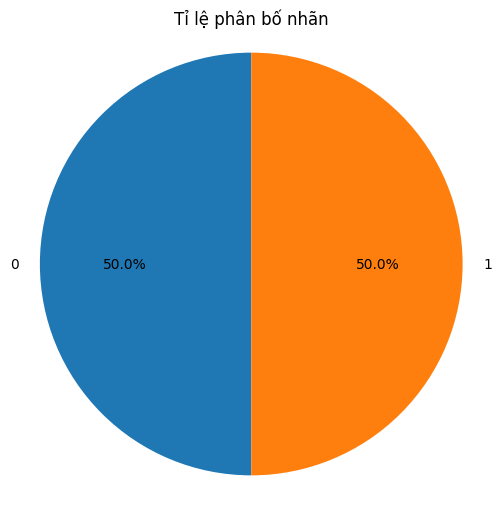

In [ ]:
label_counts = df['label'].value_counts()

# Vẽ biểu đồ tròn
plt.figure(figsize=(6,6))
plt.pie(
    label_counts,
    labels=label_counts.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Tỉ lệ phân bố nhãn')
plt.axis('equal')  # đảm bảo hình tròn
plt.show()

# Chia dữ liệu

In [ ]:
# Chia train 80% và phần còn lại 20%
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# Chia tiếp valid và test (mỗi cái 10%)
valid_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label"],
    random_state=42
)

In [ ]:
from datasets import Dataset

train_ds = Dataset.from_pandas(train_df)
valid_ds = Dataset.from_pandas(valid_df)
test_ds = Dataset.from_pandas(test_df)

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

def encode_batch(samples):
    return tokenizer(
        samples["text"],
        truncation=True,
        max_length=256,
        padding="max_length"
    )


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
# 1) Tokenize từng split
train_ds = train_ds.map(encode_batch, batched=True)
valid_ds = valid_ds.map(encode_batch, batched=True)
test_ds = test_ds.map(encode_batch, batched=True)

# 2) Loại bỏ các cột không cần thiết (id/text)
remove_cols = [col for col in train_ds.column_names if col not in ["label", "input_ids", "attention_mask"]]
train_ds = train_ds.remove_columns(remove_cols)
valid_ds = valid_ds.remove_columns(remove_cols)
test_ds = test_ds.remove_columns(remove_cols)

# 3) Gom vào DatasetDict
from datasets import DatasetDict

tokenized_datasets = DatasetDict({
    "train": train_ds,
    "valid": valid_ds,
    "test": test_ds
})

# 4) Lưu thành 1 thư mục duy nhất
tokenized_datasets.save_to_disk(tokenized_hf_data)

print(f"Saved to directory: {tokenized_hf_data}")


Map:   0%|          | 0/5355 [00:00<?, ? examples/s]

Map:   0%|          | 0/669 [00:00<?, ? examples/s]

Map:   0%|          | 0/670 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5355 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/669 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/670 [00:00<?, ? examples/s]

Saved to directory: /content/drive/MyDrive/TDTU/HK7/Natural_Language_Processing/FinalTerm/Datasets/encoder-only/tokenized_data


# Load dữ liệu

In [ ]:
from datasets import load_from_disk

tokenized_datasets = load_from_disk(tokenized_hf_data)
train_ds = tokenized_datasets["train"]
valid_ds = tokenized_datasets["valid"]
test_ds = tokenized_datasets["test"]

# Cấu hình mô hình

In [ ]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
import evaluate
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

In [ ]:
model_name = "vinai/phobert-large"   # "vinai/phobert-base"

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,  # toxic / non-toxic,
    problem_type="single_label_classification"
)

config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(eval_pred):
    """
    Tính toán các metrics cho phân loại nhị phân

    Args:
        eval_pred: Tuple (predictions, labels)

    Returns:
        dict: Dictionary chứa các metrics
    """
    predictions, labels = eval_pred

    # Convert logits to predicted class
    preds = np.argmax(predictions, axis=1)

    # Tính các metrics cơ bản
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary', pos_label=1
    )

    # Thêm metrics cho từng class
    precision_per_class, recall_per_class, f1_per_class, support = \
        precision_recall_fscore_support(labels, preds, average=None)

    # Confusion matrix
    cm = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()

    # Specificity (True Negative Rate)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    return {
        # Overall metrics
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "specificity": specificity,

        # Per-class metrics (class 0: non-toxic, class 1: toxic)
        "precision_class_0": precision_per_class[0],
        "recall_class_0": recall_per_class[0],
        "f1_class_0": f1_per_class[0],

        "precision_class_1": precision_per_class[1],
        "recall_class_1": recall_per_class[1],
        "f1_class_1": f1_per_class[1],

        # Confusion matrix elements
        "true_negative": int(tn),
        "false_positive": int(fp),
        "false_negative": int(fn),
        "true_positive": int(tp),
    }

In [ ]:
training_args = TrainingArguments(
    # Đường dẫn output
    output_dir=MODELS,

    # Training hyperparameters
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    warmup_ratio=0.1,

    # Optimization
    fp16=True,
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,

    # Evaluation & Saving
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    # Logging
    logging_dir=MODELS,
    logging_steps=10,
    report_to="none",

    # Misc
    seed=42,
    save_total_limit=2,  # Chỉ giữ 2 checkpoint tốt nhất
    push_to_hub=False,
)

# Training

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=3
        )
    ]
)

In [ ]:
# Train model
train_result = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Specificity,Precision Class 0,Recall Class 0,F1 Class 0,Precision Class 1,Recall Class 1,F1 Class 1,True Negative,False Positive,False Negative,True Positive
1,0.402200,0.369826,0.844544,0.786070,0.946108,0.858696,0.743284,0.932584,0.743284,0.827243,0.786070,0.946108,0.858696,249,86,18,316
2,0.276700,0.273128,0.889387,0.849462,0.946108,0.895184,0.832836,0.939394,0.832836,0.882911,0.849462,0.946108,0.895184,279,56,18,316
3,0.221900,0.327932,0.887892,0.864789,0.919162,0.891147,0.856716,0.914013,0.856716,0.884438,0.864789,0.919162,0.891147,287,48,27,307
4,0.103300,0.389233,0.871450,0.910596,0.823353,0.864780,0.919403,0.839237,0.919403,0.877493,0.910596,0.823353,0.864780,308,27,59,275
5,0.117900,0.449209,0.889387,0.922078,0.850299,0.884735,0.928358,0.861496,0.928358,0.893678,0.922078,0.850299,0.884735,311,24,50,284


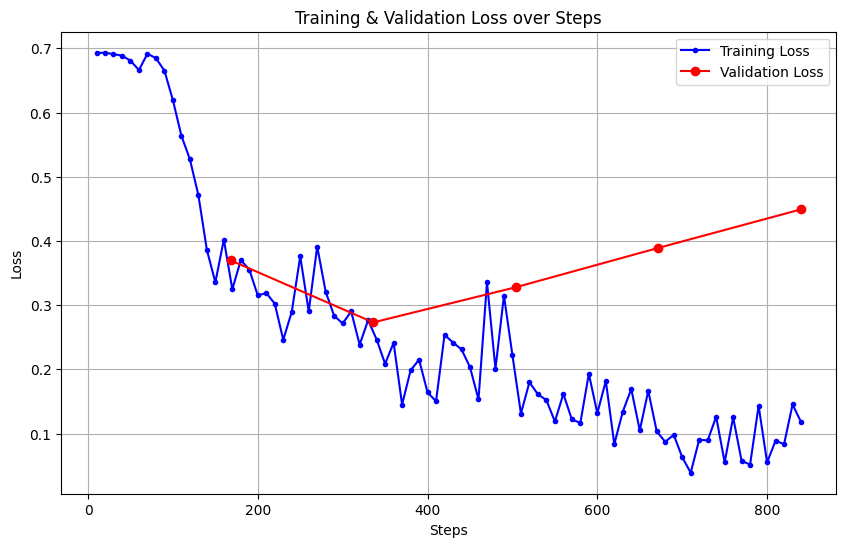

In [ ]:
import matplotlib.pyplot as plt

# 1. Trích xuất log history
log_history = trainer.state.log_history

train_loss = []
train_steps = []
eval_loss = []
eval_steps = []

for entry in log_history:
    if 'loss' in entry:
        train_loss.append(entry['loss'])
        train_steps.append(entry['step'])
    if 'eval_loss' in entry:
        eval_loss.append(entry['eval_loss'])
        eval_steps.append(entry['step'])

# 2. Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss, label='Training Loss', color='blue', marker='.')
plt.plot(eval_steps, eval_loss, label='Validation Loss', color='red', marker='o')

plt.title('Training & Validation Loss over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Đánh giá mô hình

Đang đánh giá trên tập Test...



=== Classification Report ===
               precision    recall  f1-score   support

    Toxic (0)     0.9352    0.8179    0.8726       335
Non-toxic (1)     0.8382    0.9433    0.8876       335

     accuracy                         0.8806       670
    macro avg     0.8867    0.8806    0.8801       670
 weighted avg     0.8867    0.8806    0.8801       670



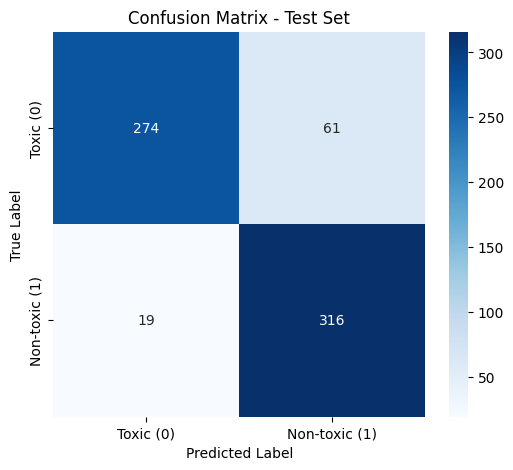


=== Metrics tổng hợp ===
{'test_loss': 0.2945740520954132, 'test_accuracy': 0.8805970149253731, 'test_precision': 0.8381962864721485, 'test_recall': 0.9432835820895522, 'test_f1': 0.8876404494382022, 'test_specificity': 0.817910447761194, 'test_precision_class_0': 0.9351535836177475, 'test_recall_class_0': 0.817910447761194, 'test_f1_class_0': 0.8726114649681529, 'test_precision_class_1': 0.8381962864721485, 'test_recall_class_1': 0.9432835820895522, 'test_f1_class_1': 0.8876404494382022, 'test_true_negative': 274, 'test_false_positive': 61, 'test_false_negative': 19, 'test_true_positive': 316, 'test_runtime': 7.5023, 'test_samples_per_second': 89.306, 'test_steps_per_second': 5.598}


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# 1. Dự đoán trên tập Test
print("Đang đánh giá trên tập Test...")
predict_result = trainer.predict(test_ds)

# 2. Lấy nhãn dự đoán và nhãn thực tế
logits = predict_result.predictions
y_pred = np.argmax(logits, axis=-1)
y_true = predict_result.label_ids

# 3. In Classification Report
target_names = ["Toxic (0)", "Non-toxic (1)"]
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

# 4. Vẽ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

# 5. In các metric tổng hợp từ trainer
print("\n=== Metrics tổng hợp ===")
print(predict_result.metrics)

In [ ]:
# Lưu mô hình
trainer.save_model(MODELS)
tokenizer.save_pretrained(MODELS)

('/content/drive/MyDrive/TDTU/HK7/Natural_Language_Processing/FinalTerm/Datasets/encoder-only/Models/tokenizer_config.json',
 '/content/drive/MyDrive/TDTU/HK7/Natural_Language_Processing/FinalTerm/Datasets/encoder-only/Models/special_tokens_map.json',
 '/content/drive/MyDrive/TDTU/HK7/Natural_Language_Processing/FinalTerm/Datasets/encoder-only/Models/vocab.txt',
 '/content/drive/MyDrive/TDTU/HK7/Natural_Language_Processing/FinalTerm/Datasets/encoder-only/Models/bpe.codes',
 '/content/drive/MyDrive/TDTU/HK7/Natural_Language_Processing/FinalTerm/Datasets/encoder-only/Models/added_tokens.json')

# Inference

In [ ]:
import torch
model = AutoModelForSequenceClassification.from_pretrained(MODELS)
tokenizer = AutoTokenizer.from_pretrained(MODELS)
model.eval()

# Test
text = "Mày là con chó"
inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
outputs = model(**inputs)
prediction = torch.argmax(outputs.logits, dim=-1)
id2label = {
    0: "toxic",
    1: "non-toxic"
}
prediction = id2label[prediction.item()]
print(prediction)

toxic
